<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-2-public/blob/adding_C2/C2/W1/assignment/C2_W1_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train Your Own Model and Convert It to TFLite

This notebook uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Fashion MNIST is intended as a drop-in replacement for the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing we'll use here.

This uses Fashion MNIST for variety, and because it's a slightly more challenging problem than regular MNIST. Both datasets are relatively small and are used to verify that an algorithm works as expected. They're good starting points to test and debug code.

We will use 60,000 images to train the network and 10,000 images to evaluate how accurately the network learned to classify images. You can access the Fashion MNIST directly from TensorFlow. Import and load the Fashion MNIST data directly from TensorFlow:

# Setup

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.6.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
• GPU Device Not Found. Running on CPU


# Download Fashion MNIST Dataset

We will use TensorFlow Datasets to load the Fashion MNIST dataset. 

**IMPORTANT NOTE:** The tfds `ALL` split has been deprecated in the latest TensorFlow version. If you are running this file on Coursera, kindly use the code:
```python
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

filePath = f"{getcwd()}/../tmp2/"
splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=splits, data_dir=filePath)

(train_examples, validation_examples, test_examples) = splits

```




If you are running the file on your local machine with the latest TensorFlow version or using Google Colab, comment out the above code and uncomment this code:

```python
(train_examples, validation_examples, test_examples), info = tfds.load('fashion_mnist', 
                                                                       with_info=True, 
                                                                       as_supervised=True, 
                                                                       split=['train[:80%]',
                                                                              'train[80%:90%]',
                                                                              'train[90%:]'])
```


In [6]:
#splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

#filePath = f"{getcwd()}/../tmp2/"
#splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=splits, data_dir=filePath)

#(train_examples, validation_examples, test_examples) = splits

(train_examples, validation_examples, test_examples), info = tfds.load('fashion_mnist', 
                                                                        with_info=True, 
                                                                        as_supervised=True, 
                                                                        split=['train[:80%]',
                                                                               'train[80%:90%]',
                                                                               'train[90%:]'])

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dataset fashion_mnist downloaded and prepared to C:\Users\david\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


The class names are not included with the dataset, so we will specify them here.

In [7]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [8]:
# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [9]:
# The images in the dataset are 28 by 28 pixels.
IMG_SIZE = 28

# Preprocessing data

## Preprocess

In [28]:
# EXERCISE: Write a function to normalize the images.

def format_example(image, label):
    # Cast image to float32
    image = tf.cast(image, tf.float32) # YOUR CODE HERE
        
    # Normalize the image in the range [0, 1]
    image = image / 255.0# YOUR CODE HERE
    label=tf.one_hot(label,num_classes)
    return image, label

In [29]:
# Specify the batch size
BATCH_SIZE = 256

## Create Datasets From Images and Labels

In [30]:
# Create Datasets
train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example)
test_batches = test_examples.batch(1).map(format_example)

# Building the Model

```
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
=================================================================
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
```

In [31]:
# EXERCISE: Build and compile the model shown in the previous cell.

model = tf.keras.Sequential([
    # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,
    tf.keras.layers.Conv2D(input_shape = (28,28,1), kernel_size=3, filters=16, activation = "relu"),# YOUR CODE HERE),
      
    tf.keras.layers.MaxPooling2D(),
      
    # Set the number of filters to 32, kernel size to 3 and use ReLU activation 
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),# YOUR CODE HERE),
      
    # Flatten the output layer to 1 dimension
    tf.keras.layers.Flatten(),
      
    # Add a fully connected layer with 64 hidden units and ReLU activation
    tf.keras.layers.Dense(units=64, activation="relu"),# YOUR CODE HERE),
      
    # Attach a final softmax classification head
    tf.keras.layers.Dense(units = num_classes, activation="softmax")]) # YOUR CODE HERE)])

# Set the appropriate loss function and use accuracy as your metric
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',# YOUR CODE HERE,
              metrics = ['accuracy'])# YOUR CODE HERE)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                247872    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 253,322
Trainable params: 253,322
Non-trainable params: 0
__________________________________________________

## Train

In [32]:
model.fit(train_batches, 
          epochs=1,
          validation_data=validation_batches)

188/188 [==============================] - 19s 96ms/step - loss: 0.6247 - accuracy: 0.7787 - val_loss: 0.4532 - val_accuracy: 0.8292


# Exporting to TFLite

You will now save the model to TFLite. We should note, that you will probably see some warning messages when running the code below. These warnings have to do with software updates and should not cause any errors or prevent your code from running. 

In [33]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'

# YOUR CODE HERE
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


In [34]:
#@title Select mode of optimization
mode = "Speed" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [35]:
# EXERCISE: Use the TFLiteConverter SavedModel API to initialize the converter

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)# YOUR CODE HERE

# Set the optimzations
converter.optimizations = [optimization]# YOUR CODE HERE

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()# YOUR CODE HERE

In [36]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

259856

# Test the Model with TFLite Interpreter 

In [37]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [38]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

In [56]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    true_label=np.argmax(true_label)
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

def plot_value_array(i, predictions_array, true_label):
    
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)), class_names, rotation='vertical')
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])
    true_label=np.argmax(true_label)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

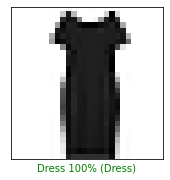

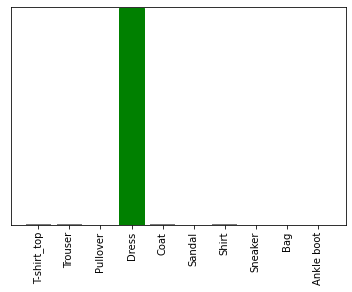

In [57]:
#@title Visualize the outputs { run: "auto" }
index = 12 #@param {type:"slider", min:1, max:50, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()

# Download the TFLite Model and Assets

If you are running this notebook in a Colab, you can run the cell below to download the tflite model and labels to your local disk.

**Note**: If the files do not download when you run the cell, try running the cell a second time. Your browser might prompt you to allow multiple files to be downloaded. 

In [ ]:
try:
    from google.colab import files
    
    files.download(tflite_model_file)
    files.download('labels.txt')
except:
    pass

# Prepare the Test Images for Download (Optional)

In [ ]:
!mkdir -p test_images

In [ ]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

In [ ]:
!ls test_images

In [ ]:
!zip -qq fmnist_test_images.zip -r test_images/

If you are running this notebook in a Colab, you can run the cell below to download the Zip file with the images to your local disk. 

**Note**: If the Zip file does not download when you run the cell, try running the cell a second time.

In [ ]:
try:
    files.download('fmnist_test_images.zip')
except:
    pass